### IMPORTS

In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

from sklearn.manifold import TSNE
import random
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

import plotly.express as px
import pandas as pd 
from tqdm import tqdm

device = 'cuda:0'
torch.cuda.set_device(0)

### Classes of InvetableLayers: RealNVP, ActNorm, InvNonlin; NormalizingFlow

In [2]:
class InvertibleLayer(nn.Module):

    def __init__(self, var_size):
        super(InvertibleLayer, self).__init__()
        self.var_size = var_size

    def f(self, x):
        '''
        Implementation of forward pass.
        
        x: torch.Tensor of shape [batch_size, var_size]

        Return:
          torch.Tensor of shape [batch_size, var_size], torch.Tensor of shape [batch_size]
        '''
        pass

    def g(self, x):
        '''
        Implementation of backward (inverse) pass.

        x: torch.Tensor of shape [batch_size, var_size]
        
        Return:
        А  torch.Tensor of shape [batch_size, var_size]
        '''
        pass

    def check_inverse(self):
        '''
        Perform check of invertibility.
        '''
        x = torch.randn(10, self.var_size)

        assert torch.norm(x - self.g(self.f(x)[0])).item() < 0.001

    def check_log_det(self):
        '''
        Perform check of log determinant.
        '''
        x = torch.randn(1, self.var_size).requires_grad_()
        _, log_det = self.f(x)

        jac = torch.autograd.functional.jacobian(lambda x: self.f(x)[0], x)
        assert torch.abs(log_det - torch.log(torch.det(jac[0, :, 0, :]))).item() < 0.001

In [3]:
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.prior = prior

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)           
            log_likelihood = log_likelihood + change if log_likelihood is not None else change      
        
        log_likelihood = log_likelihood + self.prior.log_prob(x)
        
        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))
        
        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

class RealNVP(InvertibleLayer):
    def __init__(self, var_size, mask, hidden=16):
        super(RealNVP, self).__init__(var_size=var_size)
        
        self.mask = mask

        self.nn_t = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size))
            
        self.nn_s = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size))

    def f(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(self.nn_s(x * self.mask[None, :])) # tanh важен чтобы ограничить scale снизу и сверху

        new_x = (x * torch.exp(s) + t) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        log_det = (s * (1 - self.mask[None, :])).sum(dim=-1)
        return new_x, log_det

    def g(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(self.nn_s(x * self.mask[None, :]))

        new_x = ((x - t) * torch.exp(-s)) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        return new_x

class ActNorm(InvertibleLayer):
    def __init__(self, var_size):
        super(ActNorm, self).__init__(var_size=var_size)
        
        # model w as torch.exp(self.log_w)
        self.log_w = nn.Parameter(torch.randn(var_size))
        self.bias = nn.Parameter(torch.zeros(var_size))

        self.initialized = False

    def f(self, x):
        if not self.initialized:
            self.bias.data = -x.mean(dim=0)
            self.log_w.data = -torch.log(x.std(dim=0) + 1e-1)
            self.initialized = True

        new_x = torch.exp(self.log_w[None, :]) * x + self.bias
        log_det = self.log_w.sum()
        return new_x, log_det

    def g(self, x):
        return torch.exp(-self.log_w[None, :]) * (x - self.bias)

class InvNonlin(InvertibleLayer):
    def __init__(self, var_size):
        super(InvNonlin, self).__init__(var_size=var_size)

    def f(self, x):
        mask = (torch.abs(x) < 1).float()
        pow = 3 * mask + 1 * (1 - mask)

        signs = torch.sign(x)
        new_x = signs * ((x * signs) ** pow)

        log_det = torch.log((3 * (x**2)) * mask + (1 - mask)).sum(dim=-1)

        return new_x, log_det

    def g(self, x):
        mask = (torch.abs(x) < 1).float()
        pow = (1./3) * mask + 1 * (1 - mask)

        signs = torch.sign(x)
        new_x = signs * ((x * signs) ** pow)

        return new_x

### Define encoder & decoder

In [4]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder_vae, self).__init__()
        self.lat_size = lat_size

        self.enc_net = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(3*3*32, 128), nn.ReLU())

        self.mu = nn.Linear(128, self.lat_size)
        self.log_sigma = nn.Linear(128, self.lat_size)
        
    def forward(self, x):
        z = self.enc_net(x)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        
        return mu, log_sigma 
    
class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder_vae, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size, 128), nn.ReLU(),
            nn.Linear(128, 3 * 3 * 32), nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0), nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid())
        
    def forward(self, z):

        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        return x_rec

### Define VAE

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, lat_size,
                 prior='normal', 
                 KL_weight=0.001,
                 encoder_class=MNISTEncoder_vae, 
                 decoder_class=MNISTDecoder_vae,
                 criterion_class=nn.MSELoss):
        super(VariationalAutoEncoder, self).__init__()
        
        self.mode = prior
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()

        # теперь можем использовать норм потоки в качестве прайора!
        if prior == 'normal':
            self.prior = torch.distributions.MultivariateNormal(torch.zeros(lat_size).cuda(), torch.eye(lat_size).cuda())
        elif prior == 'nf':
            prior = torch.distributions.MultivariateNormal(torch.zeros(lat_size).cuda(), torch.eye(lat_size).cuda())
            layers = []
            for i in range(16):
                    layers.append(RealNVP(var_size=lat_size, mask=((torch.arange(lat_size) + i) % 2).cuda()))
                    layers.append(ActNorm(var_size=lat_size))
                    # layers.append(RealNVP(var_size=lat_size, mask=((torch.arange(lat_size) + i) % 2).cuda()))
                    #layers.append(InvNonlin(var_size=lat_size))
            self.prior = NormalizingFlow(layers=layers, prior=prior)

        self.KL_weight = KL_weight
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, z, mu, log_sigma):
        # оценка KL по Монте Карло
        h = -self.lat_size * np.log(2 * np.pi) / 2
        h = h - ((z - mu) ** 2 / (torch.exp(log_sigma) + 1e-2) + log_sigma).sum(dim=1) / 2

        p_z = self.prior.log_prob(z)

        KL = torch.mean(h - p_z) if self.mode == 'nf' else torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
   
        recon_loss = self.criterion(x, rec_x)
        
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x, return_rec=False):
        
        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z)
        
        #normalized_angle = (angle.float() - 90.) / 90.
        loss = self.custom_loss(x, rec_x, z, mu, log_sigma)# + self.criterion(z[:,0], normalized_angle)
        
        
        return loss, rec_x if return_rec else loss

In [6]:
def train_vae(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    
    for epoch_i in range(num_epochs):        
        for iter_i, batch in enumerate(tr_dataloader):
            x, _ = batch
            x = x.to(device)
            #angle = angle.to(device)
            optimizer.zero_grad() # Зануляем градиенты
            
            loss, rec_x = model.compute_loss(x, return_rec=True)
            
            loss.backward() # Считаем градиенты
            optimizer.step() # Обновляем параметры модели
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                print(f'Epoch {epoch_i + 1}')
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('MSE(x, x_rec) + KL')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
                
    model.eval()

### Load data

In [15]:
class ElipseDataset(torch.utils.data.Dataset):
    """
    ElipseDataset - класс с описанием датасета эллипсов
    """
    def __init__(self, img_dim = (28, 28),  data_size = 1):
        
        self.img_dim = img_dim
        self.data_size = data_size
        self.data = []
        self.labels = []
        self.num_labels = 180 * [0]
        
        for _ in range(self.data_size):
            if random.randint(1, 10) > 1:
                x, y = self.img_dim
                angle = random.randint(0, 179)
                im = Image.new('1', (x,y), color = 1)
                draw = ImageDraw.Draw(im)
                x1 = random.uniform(2, x/2 - 2)
                y1 = random.uniform(x1 + 2, y/2 - 2)
                #angle = angle if abs(abs(x1 - x) - abs(y1 - y)) > 2 else 0
                #angle = angle if y1 - x1 > 1 else 0
                draw.ellipse((x1, y1, x - x1, y - y1), fill="black", outline="black")
                im = im.rotate(angle, fillcolor = 'white')
                convert_tensor = transforms.ToTensor()
                img_tensor = convert_tensor(im)
                self.data.append(img_tensor)
                self.labels.append(angle)
                #print(angle)
                self.num_labels[angle] += 1
            else:
                x, y = self.img_dim
                angle = 0
                im = Image.new('1', (x,y), color = 1)
                draw = ImageDraw.Draw(im)
                x1 = random.uniform(2, x/2 - 2)
                y1 = x1
                #angle = angle if abs(abs(x1 - x) - abs(y1 - y)) > 2 else 0
                #angle = angle if y1 - x1 > 1 else 0
                draw.ellipse((x1, y1, x - x1, y - y1), fill="black", outline="black")
                convert_tensor = transforms.ToTensor()
                img_tensor = convert_tensor(im)
                self.data.append(img_tensor)
                self.labels.append(angle)
                #print(angle)
                self.num_labels[angle] += 1
    
    def __len__(self):
        return self.data_size
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
    def random_show(self):
        rand_idx = random.randint(0, self.data_size)
        sample, sample_label = self[rand_idx]
        plt.title(sample_label)
        plt.imshow(sample.permute(1, 2, 0), cmap='gray')
    
    def label_show(self, label = 0 ):
        idxs = [i for i in range(len(self.labels)) if self.labels[i] == 0]
        print(f'samples with angle=0: {len(idxs)}\n')
        w = 10
        h = 10
        fig = plt.figure(figsize=(8, 8))
        columns = 10
        rows = 10
        #img = self.data[mask]
        for i in range(1, columns*rows +1):
            img = self.data[idxs[i]]
            fig.add_subplot(rows, columns, i)
            plt.imshow(img.permute(1,2,0), cmap='gist_gray')
        plt.show()
    
    def data_by_label(self, show_circles = True):
        plt.hist(self.labels, bins=180) if show_circles else plt.hist([label for label in self.labels if label != 0], bins=179)

def make_data(mode, train_size=50000, test_size=10000):
    if mode == 'MNIST':
        transform = transforms.Compose([transforms.ToTensor()])
        
        trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
        
        train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
        test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

    else:
        trainset = ElipseDataset(data_size = 50000)#, img_dim = (64,64))
        testset = ElipseDataset(data_size = 10000)

        train_transform = transforms.Compose([transforms.ToTensor()])
        test_transform = transforms.Compose([transforms.ToTensor()])

        trainset.transform = train_transform
        testset.transform = test_transform

        train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=100)
        test_dataloader = torch.utils.data.DataLoader(testset, batch_size=100,shuffle=True)

    return trainset, testset, train_dataloader, test_dataloader

def get_latent_vectors(model, data):
    
    encoded_samples = []
    for sample in tqdm(testset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        model.eval()
        with torch.no_grad():
            mu, log_sigma = model.encode(img)
            encoded_img = model.sample_z(mu, log_sigma)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Z{i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)

    encoded_samples = pd.DataFrame(encoded_samples)
    return encoded_samples

def visualize_latent_space(data, data_mode, mode = '2D', marker_size = 3):
    if data_mode == 'MNIST':
        data["label"] = data["label"].astype(int).astype(str)
    if mode == '2D':
        fig = px.scatter(data, x='Z0', y='Z1', color = 'label',opacity=0.7)
        fig.update_traces(marker={'size': marker_size})    
        fig.show()
    
    if mode == '3D':
        fig = px.scatter_3d(data, x='Z0', y='Z1', z='Z2', color = 'label',opacity=0.7)
        fig.update_traces(marker={'size': marker_size})    
        fig.show()

    if mode == 't-SNE':
        ddata = data.drop('label', axis=1)
        tsne = TSNE(n_components=2)
        tsne_results = tsne.fit_transform(ddata)
        df = pd.DataFrame(list(zip(tsne_results[:,0], tsne_results[:,1])), columns =['T0', 'T1'])

        #df["label"] = df["label"].astype(int).astype(str)

        fig = px.scatter(df, x='T0', y='T1', color = data['label'],opacity=0.7)
        fig.update_traces(marker={'size': 4})    
        fig.show()
            

### TESTS ON MNIST

In [8]:
trainset, testset, train_dataloader, test_dataloader = make_data(mode='MNIST')

### 2D latent space MNIST

#### VAE

In [9]:
model = VariationalAutoEncoder(lat_size=2, prior='normal')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


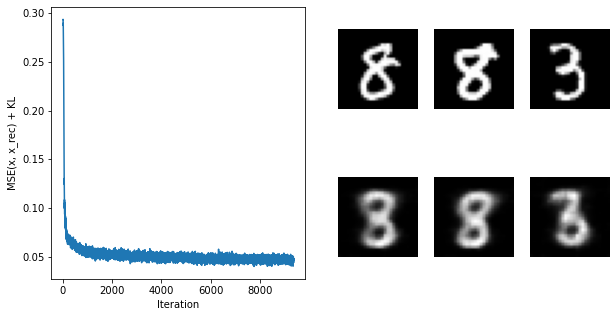

In [10]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [16]:
encoded_samples = get_latent_vectors(model=model, data=trainset)
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='2D', marker_size=3)

#### VAE+NF

In [17]:
model = VariationalAutoEncoder(lat_size=2, prior='nf')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


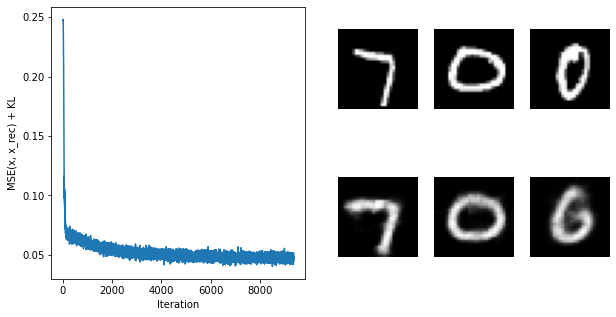

In [18]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [19]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:20<00:00, 493.95it/s]


In [21]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='2D', marker_size=3)

### 3D latent space

#### VAE

In [39]:
model = VariationalAutoEncoder(lat_size=3, prior='normal')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


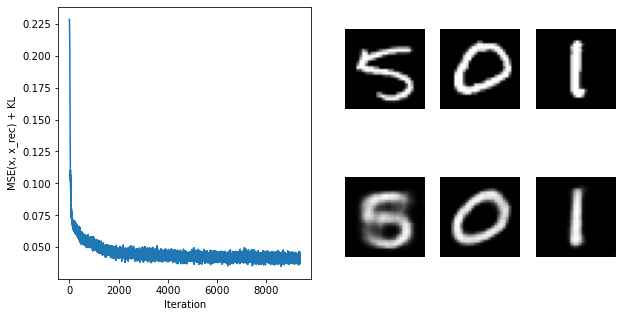

In [40]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [41]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:12<00:00, 784.68it/s]


In [43]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='3D', marker_size=2)

#### VAE+NF

In [33]:
model = VariationalAutoEncoder(lat_size=3, prior='nf')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


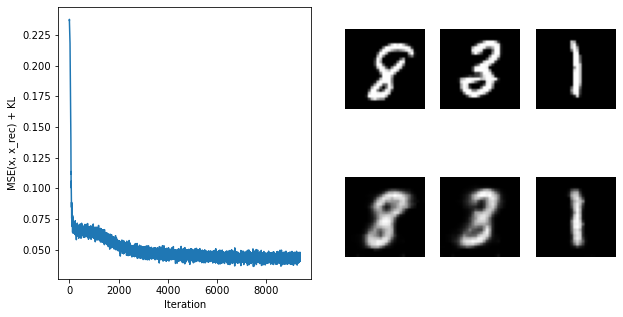

In [34]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [36]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:20<00:00, 496.63it/s]


In [38]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='3D', marker_size=2)

### 10D latent space

#### VAE

In [44]:
model = VariationalAutoEncoder(lat_size=10, prior='normal')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


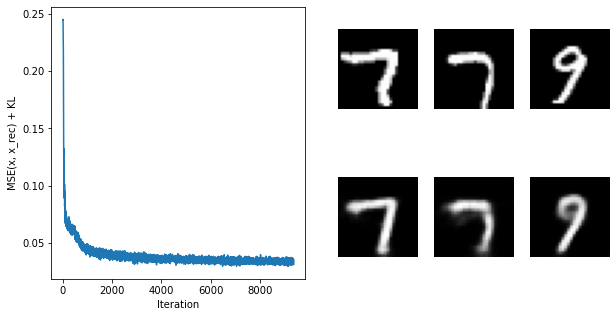

In [45]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [46]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:13<00:00, 725.49it/s]


In [47]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='t-SNE')

#### VAE+NF

In [48]:
model = VariationalAutoEncoder(lat_size=10, prior='nf')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


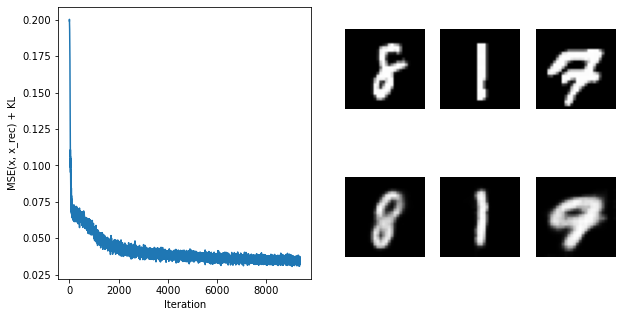

In [49]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [50]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:20<00:00, 497.06it/s]


In [52]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='t-SNE')

### 32D

In [53]:
model = VariationalAutoEncoder(lat_size=32, prior='nf')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


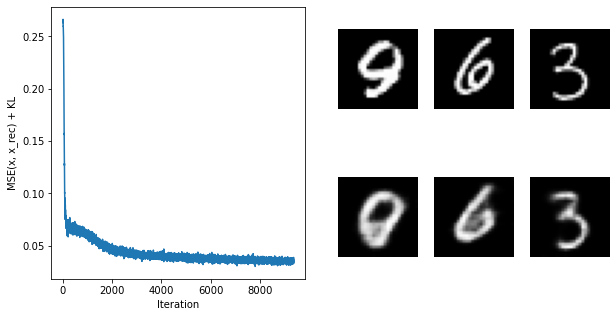

In [54]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [55]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:16<00:00, 605.39it/s]


In [56]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='t-SNE')

In [57]:
model = VariationalAutoEncoder(lat_size=32, prior='normal')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 10


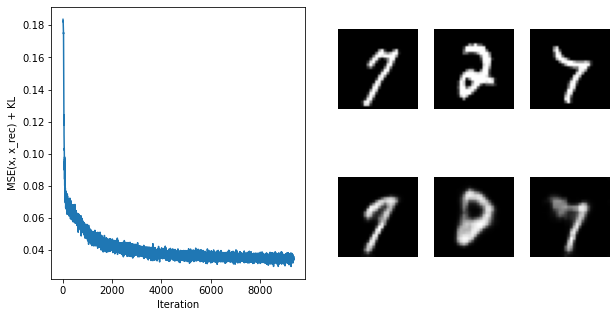

In [58]:
train_vae(model, train_dataloader, optimizer, num_epochs=10)

In [59]:
encoded_samples = get_latent_vectors(model=model, data=trainset)

100%|██████████| 10000/10000 [00:13<00:00, 753.78it/s]


In [60]:
visualize_latent_space(data=encoded_samples, data_mode='MNIST', mode='t-SNE')